In [64]:
import os
from datetime import datetime
import numpy as np
import pandas as pd
import xarray as xr
import dask.array as da
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import lightning.pytorch as pl
import pdb
import torch
import torch.nn as nn
import torch.nn.functional as F
from lightning.pytorch.callbacks import EarlyStopping
from torch.optim.lr_scheduler import ReduceLROnPlateau 

In [65]:
early_stopping = EarlyStopping(
    monitor='val/pr/rmse',  # You'll need to calculate and log val_rmse in your LightningModule
    min_delta=0.001,       # Minimum change in the monitored quantity to qualify as an improvement.
    patience=5,          # Stop after 5 epochs of no improvement
    verbose=True,
    mode='min'           # Assuming lower RMSE is better
)

In [66]:
config = {
    "data": {
        "path": "processed_data_cse151b_v2_corrupted_ssp245/processed_data_cse151b_v2_corrupted_ssp245.zarr",
        "input_vars": ["CO2", "SO2", "CH4", "BC", "rsdt"],
        "output_vars": ["pr"],  # MODIFIED
        "target_member_id": 0,
        "train_ssps": ["ssp126", "ssp370", "ssp585"],
        "test_ssp": "ssp245",
        "test_months": 360,
        "batch_size": 64,
        "num_workers": 0,
    },
    "model": {
        "type": "u_vit",
        "img_size_h": 48,
        "img_size_w": 72,
        "in_channels": 5,
        "out_channels": 1,  # MODIFIED
        "patch_size": 8,
        "hidden_size": 768,
        "num_heads": 12,# 4 before
        "num_encoder_layers": 8,
        "mlp_ratio": 4.0,
        "dropout_rate": 0.1,
        "attention_dropout_rate": 0.1,
        "decoder_init_features": 128,
        "bilinear": True,
    },
    "training": {
        "lr": 1e-4,
    },
    "trainer": {
        "max_epochs": 100,
        "accelerator": "auto",
        "devices": "auto",
        "precision": 16,
        "deterministic": True,
        "num_sanity_val_steps": 0,
        "callbacks": [] # Callbacks will be appended later if needed
    },
    "seed": 42,
}


pl.seed_everything(config["seed"])
config["trainer"]["callbacks"].append(early_stopping)

Seed set to 42


In [67]:
def get_lat_weights(latitude_values):
    lat_rad = np.deg2rad(latitude_values)
    weights = np.cos(lat_rad)
    return weights / np.mean(weights)

In [68]:
# def visualize_input_distributions(data_path, input_vars_list, train_ssps_list, 
#                                   target_member_id_val, test_months_val,
#                                   sample_every_n_timesteps=1,
#                                   apply_z_score_normalization=True,
#                                   use_log_transform_for_norm=False): # Added flag for log transform
#     """
#     Loads unnormalized training input data, optionally normalizes it, 
#     and plots the distribution of each input variable.
#     Samples data if sample_every_n_timesteps > 1.
#     """
#     if not os.path.exists(data_path):
#         print(f"Data path not found: {data_path}")
#         return

#     print(f"Loading data from: {data_path}")
#     ds = xr.open_zarr(data_path, consolidated=False, chunks={"time": "auto"}) # Adjusted chunks
    
#     try:
#         spatial_template_base = ds["rsdt"].sel(ssp=train_ssps_list[0], member_id=target_member_id_val).isel(time=0, drop=True)
#     except (KeyError, ValueError) as e: 
#         print(f"Note: Could not select rsdt with member_id for spatial_template, trying without. Error: {e}")
#         try:
#             spatial_template_base = ds["rsdt"].sel(ssp=train_ssps_list[0]).isel(time=0, drop=True)
#         except (KeyError, ValueError) as e2:
#              print(f"Critical Error: Could not load rsdt for spatial_template. Error: {e2}")
#              return

#     if "latitude" in spatial_template_base.dims:
#         spatial_template = spatial_template_base.rename({"latitude": "y", "longitude": "x"})
#     else:
#         spatial_template = spatial_template_base

#     print(f"Spatial template for broadcasting global vars (y,x): {spatial_template.dims}, {spatial_template.shape}")

#     loaded_train_inputs = []

#     print("Processing SSPs for training data distributions...")
#     for ssp_idx, ssp in enumerate(train_ssps_list):
#         print(f"  Loading SSP: {ssp}")
#         input_dask_ssp = []
#         for var_idx, var_name in enumerate(input_vars_list):
#             try:
#                 da_var = ds[var_name].sel(ssp=ssp)
                
#                 if "latitude" in da_var.dims:
#                     da_var = da_var.rename({"latitude": "y", "longitude": "x"})
                
#                 if "member_id" in da_var.dims:
#                     da_var = da_var.sel(member_id=target_member_id_val)
                
#                 is_global = True
#                 for dim_name in da_var.dims:
#                     if dim_name not in ['time', 'member_id']: 
#                         is_global = False
#                         break
                
#                 if is_global and 'y' not in da_var.dims and 'x' not in da_var.dims : 
#                     print(f"    Broadcasting global variable: {var_name}")
#                     da_var = da_var.broadcast_like(spatial_template).transpose("time", "y", "x")
                
#                 input_dask_ssp.append(da_var.data)
#             except Exception as e:
#                 print(f"    Error processing variable {var_name} in SSP {ssp}: {e}")
#                 return 

#         if not input_dask_ssp:
#             print(f"  No input data loaded for SSP: {ssp}. Skipping.")
#             continue
            
#         ssp_input_data = da.stack(input_dask_ssp, axis=1) # (time, vars, H, W)

#         if ssp == "ssp370": 
#             print(f"    SSP {ssp}: Using data up to last {test_months_val} months for training distribution.")
#             loaded_train_inputs.append(ssp_input_data[:-test_months_val])
#         else:
#             loaded_train_inputs.append(ssp_input_data)

#     if not loaded_train_inputs:
#         print("No training data could be loaded. Aborting visualization.")
#         return

#     # all_train_inputs_unnormalized shape: (total_train_time_steps, num_input_vars, H, W)
#     all_train_inputs_unnormalized = da.concatenate(loaded_train_inputs, axis=0)

#     print(f"\nShape of combined unnormalized training input data (Time, Vars, H, W): {all_train_inputs_unnormalized.shape}")
    
#     data_to_plot = all_train_inputs_unnormalized
#     plot_title_suffix = "(Unnormalized Training Data)"

#     if sample_every_n_timesteps > 1:
#         print(f"Sampling data: using every {sample_every_n_timesteps}-th time step.")
#         data_to_plot = data_to_plot[::sample_every_n_timesteps, :, :, :]
#         print(f"Shape after sampling: {data_to_plot.shape}")
    
#     # --- Apply Normalization if requested ---
#     if apply_z_score_normalization:
#         print(f"\nApplying Z-score normalization (log_transform_input={use_log_transform_for_norm})...")
#         # Calculate mean and std for normalization from the *sampled* data to be plotted
#         # This should ideally be from the full training set if these stats were to be used for model training,
#         # but for visualization of the *effect* of normalization on the *sampled data*, this is fine.
#         # For true training stats, use the `normalizer` from `ClimateDataModule`.
        
#         # Compute stats per variable (across time, H, W)
#         # Shape of mean_for_norm, std_for_norm: (num_input_vars,)
#         mean_for_norm_dask = da.nanmean(data_to_plot, axis=(0, 2, 3)) 
#         std_for_norm_dask = da.nanstd(data_to_plot, axis=(0, 2, 3))
        
#         print("  Computing mean and std for normalization...")
#         mean_for_norm = mean_for_norm_dask.compute()
#         std_for_norm = std_for_norm_dask.compute()
#         std_for_norm[std_for_norm == 0] = 1e-9 # Avoid division by zero
#         print(f"  Mean per variable for normalization: {mean_for_norm}")
#         print(f"  Std per variable for normalization: {std_for_norm}")

#         # Apply normalization variable by variable
#         normalized_vars_list = []
#         local_normalizer = Normalizer(log_transform_input=use_log_transform_for_norm)

#         for i in range(data_to_plot.shape[1]): # Iterate over variables
#             var_data_dask = data_to_plot[:, i, :, :] # (time, H, W)
            
#             # Set stats for the current variable
#             local_normalizer.set_input_statistics(mean_for_norm[i], std_for_norm[i])
            
#             # Normalizer expects numpy array, so compute here.
#             # This means we compute for each var, then normalize.
#             var_data_np = var_data_dask.compute() 
            
#             normalized_var_data_np = local_normalizer.normalize(var_data_np, "input")
#             normalized_vars_list.append(da.from_array(normalized_var_data_np, chunks=var_data_dask.chunks)) # Convert back to dask
            
#         data_to_plot = da.stack(normalized_vars_list, axis=1) # (time, vars, H, W)
#         plot_title_suffix = f"(Z-Score Normalized, log_transform={use_log_transform_for_norm})"
#         print("Normalization applied.")
#         print(f"Shape after normalization: {data_to_plot.shape}")


#     print(f"\nInput variables being plotted: {input_vars_list}")
#     num_vars = data_to_plot.shape[1]
    
#     n_cols = min(3, num_vars) 
#     n_rows = (num_vars + n_cols - 1) // n_cols 
    
#     fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, n_rows * 4.5), squeeze=False)
#     axes = axes.flatten() 

#     for i in range(num_vars):
#         if i >= len(axes): 
#             print(f"Warning: Not enough axes for variable {input_vars_list[i]}")
#             break
            
#         var_name = input_vars_list[i]
#         var_data_dask_single_var = data_to_plot[:, i, :, :] # (time, H, W)
        
#         print(f"\nComputing and plotting for {var_name}...")
#         try:
#             # .compute() is now on potentially normalized dask array for this single variable
#             var_data_flat = var_data_dask_single_var.compute().flatten()
#         except Exception as e:
#             print(f"  Error computing data for {var_name}: {e}. Skipping this variable.")
#             axes[i].set_title(f"Error loading {var_name}")
#             axes[i].text(0.5, 0.5, "Error during data computation.", 
#                          horizontalalignment='center', verticalalignment='center', transform=axes[i].transAxes)
#             continue
            
#         print(f"  Data for {var_name} (flat for hist): {var_data_flat.shape}")

#         ax = axes[i]
#         ax.hist(var_data_flat, bins=50, color='skyblue', edgecolor='black', density=True)
#         ax.set_title(f"Distribution of {var_name}\n{plot_title_suffix}", fontsize=10)
#         ax.set_xlabel("Value", fontsize=9)
#         ax.set_ylabel("Density", fontsize=9)
#         ax.grid(True, linestyle='--', alpha=0.7)
#         ax.tick_params(axis='both', which='major', labelsize=8)
#         if apply_z_score_normalization: # Normalized data is usually around 0
#              ax.ticklabel_format(style='plain', axis='x')
#         else: # Unnormalized data might need scientific notation
#             ax.ticklabel_format(style='sci', axis='x', scilimits=(-3,3))


#         mean_val = np.mean(var_data_flat)
#         std_val = np.std(var_data_flat)
#         median_val = np.median(var_data_flat)
#         min_val = np.min(var_data_flat)
#         max_val = np.max(var_data_flat)
#         skew_val = pd.Series(var_data_flat).skew() if len(var_data_flat) > 0 else np.nan
        
#         stats_text = (f"Mean: {mean_val:.2e}\nStd: {std_val:.2e}\nMedian: {median_val:.2e}\n"
#                       f"Min: {min_val:.2e}\nMax: {max_val:.2e}\nSkew: {skew_val:.2f}")
#         ax.text(0.97, 0.97, stats_text, transform=ax.transAxes, fontsize=7,
#                 verticalalignment='top', horizontalalignment='right',
#                 bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.85))

#     for j in range(num_vars, len(axes)):
#         fig.delaxes(axes[j])

#     plt.tight_layout(pad=2.0)
#     plt.suptitle(f"Distributions of Input Variables {plot_title_suffix}", fontsize=14, y=1.03 if n_rows > 1 else 1.06)
#     plt.show()

# # --- Call the function ---
# print("--- Visualizing Input Variable Distributions ---")
# visualize_input_distributions(
#     config["data"]["path"],
#     config["data"]["input_vars"],
#     config["data"]["train_ssps"],
#     config["data"]["target_member_id"],
#     config["data"]["test_months"],
#     sample_every_n_timesteps=10,  # Adjust this value as needed. 1 means no sampling.
#     apply_z_score_normalization=True, # Set to True to see normalized plots
#     use_log_transform_for_norm=False # Set to False for pure Z-score as requested
# )
# print("--- Finished visualizing ---")

In [69]:
class _UpBlock(nn.Module):
    """
    An upsampling block for the decoder.
    """
    def __init__(self, in_channels, out_channels, use_bilinear=True):
        super().__init__()
        if use_bilinear:
            self.up = nn.Sequential(
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(out_channels), # Added BatchNorm for stability
                nn.ReLU(inplace=True)
            )
        else:
            self.up = nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
                nn.BatchNorm2d(out_channels), # Added BatchNorm for stability
                nn.ReLU(inplace=True)
            )
        
        # Additional conv layers to refine features, common in U-Net decoders
        self.conv_block = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )


    def forward(self, x):
        x = self.up(x)
        return self.conv_block(x)

class SimpleViTRegressor(nn.Module):
    def __init__(self, img_size_h, img_size_w, patch_size, in_channels, out_channels,
                 hidden_size, num_heads, num_encoder_layers, mlp_ratio,
                 dropout_rate, attention_dropout_rate, # Note: attention_dropout_rate not directly used by nn.TransformerEncoderLayer
                 decoder_init_features, bilinear):
        super().__init__()

        if img_size_h % patch_size != 0 or img_size_w % patch_size != 0:
            raise ValueError("Image dimensions must be divisible by patch_size.")

        self.img_size_h = img_size_h
        self.img_size_w = img_size_w
        self.patch_size = patch_size
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.hidden_size = hidden_size

        self.num_patches_h = img_size_h // patch_size
        self.num_patches_w = img_size_w // patch_size
        self.num_patches = self.num_patches_h * self.num_patches_w

        # 1. Patch Embedding
        # Efficiently creates patches and projects them.
        self.patch_embed = nn.Conv2d(in_channels, hidden_size,
                                     kernel_size=patch_size, stride=patch_size)

        # 2. Positional Embedding
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches, hidden_size))
        self.pos_drop = nn.Dropout(p=dropout_rate)

        # 3. Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_size,
            nhead=num_heads,
            dim_feedforward=int(hidden_size * mlp_ratio),
            dropout=dropout_rate, # This dropout applies to MHA and FFN
            activation=F.gelu,    # GELU is common in ViTs
            batch_first=True,     # Input: (Batch, Seq, Feature)
            norm_first=True       # Pre-LN for stability
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_encoder_layers
        )
        # Final normalization after the encoder stack
        self.encoder_norm = nn.LayerNorm(hidden_size)

        # 4. Decoder
        num_upsamples = int(np.log2(patch_size))
        if patch_size <= 0 or (patch_size & (patch_size - 1)) != 0 and patch_size != 1: # check if power of 2
             raise ValueError("patch_size must be a power of 2 for this decoder logic.")


        decoder_layers = []
        current_channels = hidden_size

        # Channel progression for decoder blocks (output channels of each UpBlock)
        # E.g., for patch_size=8 (3 upsamples), decoder_init_features=128:
        # UpBlock1 out: 128*4=512 channels
        # UpBlock2 out: 128*2=256 channels
        # UpBlock3 out: 128*1=128 channels
        for i in range(num_upsamples):
            out_block_channels = decoder_init_features * (2**(num_upsamples - 1 - i))
            decoder_layers.append(_UpBlock(current_channels, out_block_channels, use_bilinear=bilinear))
            current_channels = out_block_channels
        
        self.decoder_blocks = nn.Sequential(*decoder_layers)

        # Final convolution to map to out_channels
        self.decoder_final_conv = nn.Conv2d(current_channels, out_channels, kernel_size=1)

    def forward(self, x):
        B, C, H, W = x.shape

        # Patch Embedding
        # x: (B, in_channels, H, W) -> (B, hidden_size, H/P, W/P)
        x = self.patch_embed(x)
        # Flatten: (B, hidden_size, H/P, W/P) -> (B, hidden_size, num_patches)
        # Transpose: (B, hidden_size, num_patches) -> (B, num_patches, hidden_size)
        x = x.flatten(2).transpose(1, 2)

        # Add Positional Embedding
        x = x + self.pos_embed
        x = self.pos_drop(x)

        # Transformer Encoder
        x = self.transformer_encoder(x) # Output: (B, num_patches, hidden_size)
        x = self.encoder_norm(x)

        # Reshape for Decoder
        # (B, num_patches, hidden_size) -> (B, hidden_size, num_patches_h, num_patches_w)
        x = x.transpose(1, 2).reshape(B, self.hidden_size, self.num_patches_h, self.num_patches_w)

        # Decoder
        x = self.decoder_blocks(x) # Output: (B, decoder_init_features, H, W)
        x = self.decoder_final_conv(x)   # Output: (B, out_channels, H, W)

        return x


In [70]:
class Normalizer:
    def __init__(self, log_transform_input=False, log_transform_output=False):
        self.mean_in, self.std_in = None, None
        self.mean_out, self.std_out = None, None
        self.log_transform_input = log_transform_input
        self.log_transform_output = log_transform_output
        self.epsilon = 1e-10  # small constant to avoid log(0)

    def set_input_statistics(self, mean, std):
        self.mean_in = mean
        self.std_in = std

    def set_output_statistics(self, mean, std):
        self.mean_out = mean
        self.std_out = std

    def normalize(self, data, data_type):
        if data_type == "input":
            if self.log_transform_input:
                data = np.log(data + self.epsilon)
            return (data - self.mean_in) / self.std_in
        elif data_type == "output":
            if self.log_transform_output:
                data = np.log(data + self.epsilon)
            return (data - self.mean_out) / self.std_out

    def inverse_transform_output(self, data):
        denormalized = data * self.std_out + self.mean_out
        if self.log_transform_output:
            return np.exp(denormalized) - self.epsilon
        return denormalized

    def inverse_transform_input(self, data):
        denormalized = data * self.std_in + self.mean_in
        if self.log_transform_input:
            return np.exp(denormalized) - self.epsilon
        return denormalized

In [71]:
class ClimateDataset(Dataset):
    """
    A PyTorch Dataset for climate data, handling Dask arrays and converting to PyTorch tensors.
    """
    def __init__(self, inputs_dask, outputs_dask, output_is_normalized=True):
        self.size = inputs_dask.shape[0]
        print(f"Creating dataset with {self.size} samples...")

        # Compute Dask arrays to NumPy arrays
        # This will load data into memory, ensure you have enough RAM for your dataset size
        inputs_np = inputs_dask.compute()
        outputs_np = outputs_dask.compute()

        # Convert NumPy arrays to PyTorch tensors
        self.inputs = torch.from_numpy(inputs_np).float()
        self.outputs = torch.from_numpy(outputs_np).float()

        # Basic NaN check
        if torch.isnan(self.inputs).any() or torch.isnan(self.outputs).any():
            raise ValueError("NaNs found in dataset after Dask compute.")

    def __len__(self):
        """Returns the total number of samples in the dataset."""
        return self.size

    def __getitem__(self, idx):
        """
        Retrieves an input-output pair by index.
        Args:
            idx (int): The index of the sample to retrieve.
        Returns:
            tuple: (input_tensor, output_tensor)
        """
        return self.inputs[idx], self.outputs[idx]


class ClimateDataModule(pl.LightningDataModule):
    """
    A PyTorch Lightning DataModule for managing climate data loading,
    preprocessing, and splitting into train, validation, and test sets.
    """
    def __init__(
        self,
        path,
        input_vars,
        output_vars,
        train_ssps,
        test_ssp,
        val_split=0.1,
        test_months=360,
        batch_size=32,
        num_workers=0,
        seed=42,
    ):
        super().__init__()
        self.path = path
        self.input_vars = input_vars
        self.output_vars = output_vars
        self.train_ssps = train_ssps
        self.test_ssp = test_ssp
        self.val_split = val_split
        self.test_months = test_months
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.seed = seed
        # Initialize normalizer with log transform for output variables (e.g., precipitation)
        self.normalizer = Normalizer(log_transform_output=True)

    def prepare_data(self):
        """
        Checks if the data path exists. This is called once per node.
        """
        assert os.path.exists(self.path), f"Data path not found: {self.path}"

    def setup(self, stage=None):
        """
        Loads and preprocesses the data, setting up the train, validation, and test datasets.
        This is called on every GPU.
        """
        # Open the Zarr dataset. Chunks={"time": 24} allows efficient time-series access.
        ds = xr.open_zarr(self.path, consolidated=False, chunks={"time": 24})
        # Get a spatial template for broadcasting global variables
        spatial_template = ds["rsdt"].isel(time=0, ssp=0, drop=True)

        def load_ssp(ssp_scenario):
            """
            Loads input and output data for a given SSP scenario,
            averaging across ensemble members.
            """
            input_dask_list, output_dask_list = [], []

            # Process input variables
            for var in self.input_vars:
                da_var = ds[var].sel(ssp=ssp_scenario)
                if "latitude" in da_var.dims:
                    da_var = da_var.rename({"latitude": "y", "longitude": "x"})
                if "member_id" in da_var.dims:
                    # Average across the 'member_id' dimension for input variables
                    da_var = da_var.mean('member_id')
                if set(da_var.dims) == {"time"}:
                    # Broadcast global variables (like CO2, SO2) to match spatial dimensions
                    da_var = da_var.broadcast_like(spatial_template).transpose("time", "y", "x")
                input_dask_list.append(da_var.data)

            # Process output variables
            for var in self.output_vars:
                da_out = ds[var].sel(ssp=ssp_scenario)
                if "member_id" in da_out.dims:
                    # Average across the 'member_id' dimension for output variables
                    da_out = da_out.mean('member_id')
                if "latitude" in da_out.dims:
                    da_out = da_out.rename({"latitude": "y", "longitude": "x"})
                output_dask_list.append(da_out.data)

            # Stack variables along a new channel dimension (axis=1)
            return da.stack(input_dask_list, axis=1), da.stack(output_dask_list, axis=1)

        train_input_parts, train_output_parts = [], []
        val_input_dask, val_output_dask = None, None

        # Load and split training and validation data
        for ssp in self.train_ssps:
            x, y = load_ssp(ssp)
            if ssp == "ssp370":
                # Use the last `test_months` of ssp370 for validation
                val_input_dask = x[-self.test_months:]
                val_output_dask = y[-self.test_months:]
                train_input_parts.append(x[:-self.test_months])
                train_output_parts.append(y[:-self.test_months])
            else:
                train_input_parts.append(x)
                train_output_parts.append(y)

        # Concatenate all training data parts
        train_input_dask = da.concatenate(train_input_parts, axis=0)
        train_output_dask = da.concatenate(train_output_parts, axis=0)

        # Calculate normalization statistics on the training data
        # Using nanmean/nanstd to handle potential NaN values if any exist
        self.normalizer.set_input_statistics(
            mean=da.nanmean(train_input_dask, axis=(0, 2, 3), keepdims=True).compute(),
            std=da.nanstd(train_input_dask, axis=(0, 2, 3), keepdims=True).compute(),
        )
        self.normalizer.set_output_statistics(
            mean=da.nanmean(train_output_dask, axis=(0, 2, 3), keepdims=True).compute(),
            std=da.nanstd(train_output_dask, axis=(0, 2, 3), keepdims=True).compute(),
        )

        # Normalize the datasets
        train_input_norm = self.normalizer.normalize(train_input_dask, "input")
        train_output_norm = self.normalizer.normalize(train_output_dask, "output")
        val_input_norm = self.normalizer.normalize(val_input_dask, "input")
        val_output_norm = self.normalizer.normalize(val_output_dask, "output")

        # Load test data
        test_input_dask, test_output_dask = load_ssp(self.test_ssp)
        # Use the last `test_months` for the test set
        test_input_dask = test_input_dask[-self.test_months:]
        test_output_dask = test_output_dask[-self.test_months:]
        # Normalize test inputs, but keep test outputs unnormalized for direct comparison
        test_input_norm = self.normalizer.normalize(test_input_dask, "input")

        # Create PyTorch Dataset instances
        self.train_dataset = ClimateDataset(train_input_norm, train_output_norm)
        self.val_dataset = ClimateDataset(val_input_norm, val_output_norm)
        # Test dataset outputs are not normalized as they are the ground truth for evaluation
        self.test_dataset = ClimateDataset(test_input_norm, test_output_dask, output_is_normalized=False)

        # Store latitude and longitude for plotting/analysis
        self.lat = spatial_template.y.values
        self.lon = spatial_template.x.values
        # Calculate area weights for spatial averaging (e.g., for metrics)
        self.area_weights = xr.DataArray(get_lat_weights(self.lat), dims=["y"], coords={"y": self.lat})

    def train_dataloader(self):
        """Returns the DataLoader for the training set."""
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True,
                          num_workers=self.num_workers, pin_memory=True)

    def val_dataloader(self):
        """Returns the DataLoader for the validation set."""
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False,
                          num_workers=self.num_workers, pin_memory=True)

    def test_dataloader(self):
        """Returns the DataLoader for the test set."""
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False,
                          num_workers=self.num_workers, pin_memory=True)

    def get_lat_weights(self):
        """Returns the latitude area weights."""
        return self.area_weights

    def get_coords(self):
        """Returns the latitude and longitude coordinates."""
        return self.lat, self.lon

In [72]:
cdm = ClimateDataModule(
    path=config["data"]["path"],
        input_vars=config["data"]["input_vars"],
        output_vars=config["data"]["output_vars"],
        train_ssps=config["data"]["train_ssps"],
        test_ssp=config["data"]["test_ssp"],
        test_months=config["data"]["test_months"],
        batch_size=config["data"]["batch_size"],
        num_workers=config["data"]["num_workers"],
        seed=config["seed"],
)
cdm.prepare_data()
cdm.setup()
# print the shape of train, validation, and test datasets
print(f"Train dataset shape: {len(cdm.train_dataset)}, {cdm.train_dataset.outputs.shape}")
print(f"Validation dataset shape: {cdm.val_dataset.inputs.shape}, {cdm.val_dataset.outputs.shape}")
print(f"Test dataset shape: {cdm.test_dataset.inputs.shape}, {cdm.test_dataset.outputs.shape}")

Creating dataset with 2703 samples...
Creating dataset with 360 samples...
Creating dataset with 360 samples...
Train dataset shape: 2703, torch.Size([2703, 1, 48, 72])
Validation dataset shape: torch.Size([360, 5, 48, 72]), torch.Size([360, 1, 48, 72])
Test dataset shape: torch.Size([360, 5, 48, 72]), torch.Size([360, 1, 48, 72])


In [73]:
import os
from datetime import datetime
import numpy as np
import pandas as pd
import xarray as xr
import dask.array as da
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import lightning.pytorch as pl
import pdb
import torch.nn.functional as F
from lightning.pytorch.callbacks import EarlyStopping
from torch.optim.lr_scheduler import ReduceLROnPlateau # Make sure this is imported

class ClimateEmulationModule(pl.LightningModule):
    def __init__(self, model, learning_rate=1e-4):
        super().__init__()
        self.model = model
        self.save_hyperparameters(ignore=['model'])
        self.criterion = nn.MSELoss()
        self.normalizer = None
        self.val_preds, self.val_targets = [], []
        self.test_preds, self.test_targets = [], []
        self.train_losses = [] # Initialize list to store training losses
        self.val_losses = []   # Initialize list to store validation losses

    def forward(self, x):
        return self.model(x)

    def on_fit_start(self):
        self.normalizer = self.trainer.datamodule.normalizer

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("train/loss", loss)
        self.train_losses.append(loss.item()) # Append training loss for plotting
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("val/loss", loss)
        self.val_losses.append(loss.item()) # Append validation loss for plotting

        y_hat_np = self.normalizer.inverse_transform_output(y_hat.detach().cpu().numpy())
        y_np = self.normalizer.inverse_transform_output(y.detach().cpu().numpy())
        self.val_preds.append(y_hat_np)
        self.val_targets.append(y_np)
        return loss

    def on_validation_epoch_end(self):
        preds = np.concatenate(self.val_preds, axis=0)
        trues = np.concatenate(self.val_targets, axis=0)
        self._evaluate(preds, trues, phase="val")
        np.save("val_preds.npy", preds)
        np.save("val_trues.npy", trues)
        self.val_preds.clear()
        self.val_targets.clear()

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        y_hat_np = self.normalizer.inverse_transform_output(y_hat.detach().cpu().numpy())
        y_np = y.detach().cpu().numpy()
        self.test_preds.append(y_hat_np)
        self.test_targets.append(y_np)

    def on_test_epoch_end(self):
        preds = np.concatenate(self.test_preds, axis=0)
        trues = np.concatenate(self.test_targets, axis=0)
        self._evaluate(preds, trues, phase="test")
        self._save_submission(preds)
        self.test_preds.clear()
        self.test_targets.clear()

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.hparams.learning_rate)
        
        scheduler = {
            'scheduler': ReduceLROnPlateau(
                optimizer,
                mode='min',
                factor=0.5,
                patience=3,
                min_lr=1e-7,
            ),
            'monitor': 'val/pr/rmse',  # <-- this goes outside the scheduler object
            'interval': 'epoch',
            'frequency': 1,
        }
    
        return [optimizer], [scheduler]

    def _evaluate(self, preds, trues, phase="val"):
        datamodule = self.trainer.datamodule
        area_weights = datamodule.get_lat_weights()
        lat, lon = datamodule.get_coords()
        time = np.arange(preds.shape[0])
        output_vars = datamodule.output_vars

        for i, var in enumerate(output_vars):
            p = preds[:, i]
            t = trues[:, i]
            p_xr = xr.DataArray(p, dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})
            t_xr = xr.DataArray(t, dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})

            # RMSE
            rmse = np.sqrt(((p_xr - t_xr) ** 2).weighted(area_weights).mean(("time", "y", "x")).item())
            # RMSE of time-mean
            mean_rmse = np.sqrt(((p_xr.mean("time") - t_xr.mean("time")) ** 2).weighted(area_weights).mean(("y", "x")).item())
            # MAE of time-stddev
            std_mae = np.abs(p_xr.std("time") - t_xr.std("time")).weighted(area_weights).mean(("y", "x")).item()

            print(f"[{phase.upper()}] {var}: RMSE={rmse:.4f}, Time-Mean RMSE={mean_rmse:.4f}, Time-Stddev MAE={std_mae:.4f}")
            self.log_dict({
                f"{phase}/{var}/rmse": rmse,
                f"{phase}/{var}/time_mean_rmse": mean_rmse,
                f"{phase}/{var}/time_std_mae": std_mae,
            })

    def _save_submission(self, predictions):
        datamodule = self.trainer.datamodule
        lat, lon = datamodule.get_coords()
        output_vars = datamodule.output_vars
        time = np.arange(predictions.shape[0])

        rows = []
        for t_idx, t in enumerate(time):
            for var_idx, var in enumerate(output_vars):
                for y_idx, y in enumerate(lat):
                    for x_idx, x in enumerate(lon):
                        row_id = f"t{t_idx:03d}_{var}_{y:.2f}_{x:.2f}"
                        pred = predictions[t_idx, var_idx, y_idx, x_idx]
                        rows.append({"ID": row_id, "Prediction": pred})

        df = pd.DataFrame(rows)
        os.makedirs("submissions", exist_ok=True)
        filepath = f"submissions/kaggle_submission_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
        df.to_csv(filepath, index=False)
        print(f"✅ Submission saved to: {filepath}")

In [74]:
model = SimpleViTRegressor(
        img_size_h=config["model"]["img_size_h"],
        img_size_w=config["model"]["img_size_w"],
        patch_size=config["model"]["patch_size"],
        in_channels=config["model"]["in_channels"],
        out_channels=config["model"]["out_channels"],
        hidden_size=config["model"]["hidden_size"],
        num_heads=config["model"]["num_heads"],
        num_encoder_layers=config["model"]["num_encoder_layers"],
        mlp_ratio=config["model"]["mlp_ratio"],
        dropout_rate=config["model"]["dropout_rate"],
        attention_dropout_rate=config["model"]["attention_dropout_rate"],
        decoder_init_features=config["model"]["decoder_init_features"],
        bilinear=config["model"]["bilinear"],
    )
climate_model = ClimateEmulationModule(
    model=model,
    learning_rate=config["training"]["lr"],
)

trainer = pl.Trainer(
        max_epochs=config["trainer"]["max_epochs"],
        accelerator=config["trainer"]["accelerator"],
        devices=config["trainer"]["devices"],
        precision=config["trainer"]["precision"],
        deterministic=config["trainer"]["deterministic"],
        num_sanity_val_steps=config["trainer"]["num_sanity_val_steps"],
        callbacks=config["trainer"]["callbacks"],
        # logger=logger, # Uncomment if you set up a logger
    )

/home/dpachchigar/.local/lib/python3.11/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
/home/dpachchigar/.local/lib/python3.11/site-packages/lightning/fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
# last 1.18 mean and rmse of 3.99
# Train the model
print("Starting training...")
trainer.fit(climate_model, cdm)
print("Training finished.")

Starting training...
Creating dataset with 2703 samples...
Creating dataset with 360 samples...
Creating dataset with 360 samples...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | SimpleViTRegressor | 68.2 M | train
1 | criterion | MSELoss            | 0      | train
---------------------------------------------------------
68.2 M    Trainable params
0         Non-trainable params
68.2 M    Total params
272.819   Total estimated model params size (MB)
128       Modules in train mode
0         Modules in eval mode
/home/dpachchigar/.local/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=39` in the `DataLoader` to improve performance.
/home/dpachchigar/.local/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/pr/rmse improved. New best score: 3.112


[VAL] pr: RMSE=3.1119, Time-Mean RMSE=2.1378, Time-Stddev MAE=1.5519


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] pr: RMSE=3.3250, Time-Mean RMSE=2.4086, Time-Stddev MAE=1.2472


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/pr/rmse improved by 0.099 >= min_delta = 0.001. New best score: 3.013


[VAL] pr: RMSE=3.0126, Time-Mean RMSE=2.0538, Time-Stddev MAE=1.3022


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/pr/rmse improved by 0.377 >= min_delta = 0.001. New best score: 2.635


[VAL] pr: RMSE=2.6355, Time-Mean RMSE=1.5026, Time-Stddev MAE=1.1479


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] pr: RMSE=2.6608, Time-Mean RMSE=1.5031, Time-Stddev MAE=1.0863


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/pr/rmse improved by 0.138 >= min_delta = 0.001. New best score: 2.497


[VAL] pr: RMSE=2.4975, Time-Mean RMSE=1.3566, Time-Stddev MAE=1.0571


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/pr/rmse improved by 0.322 >= min_delta = 0.001. New best score: 2.175


[VAL] pr: RMSE=2.1753, Time-Mean RMSE=1.0857, Time-Stddev MAE=0.9021


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/pr/rmse improved by 0.289 >= min_delta = 0.001. New best score: 1.886


[VAL] pr: RMSE=1.8863, Time-Mean RMSE=0.9270, Time-Stddev MAE=0.6776


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] pr: RMSE=1.9057, Time-Mean RMSE=0.9626, Time-Stddev MAE=0.5661


In [61]:
trainer.test(climate_model, datamodule=cdm) 

Creating dataset with 2703 samples...
Creating dataset with 360 samples...
Creating dataset with 360 samples...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/dpachchigar/.local/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=39` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

[TEST] pr: RMSE=3.9952, Time-Mean RMSE=3.5262, Time-Stddev MAE=1.3240
✅ Submission saved to: submissions/kaggle_submission_20250524_013758.csv


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/pr/rmse        │    3.9951729774475098     │
│  test/pr/time_mean_rmse   │    3.5262224674224854     │
│   test/pr/time_std_mae    │    1.3240165710449219     │
└───────────────────────────┴───────────────────────────┘

[{'test/pr/rmse': 3.9951729774475098,
  'test/pr/time_mean_rmse': 3.5262224674224854,
  'test/pr/time_std_mae': 1.3240165710449219}]

In [62]:
def plot_comparison(true_xr, pred_xr, title, cmap='viridis', diff_cmap='RdBu_r', metric=None):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    vmin = min(true_xr.min().item(), pred_xr.min().item())
    vmax = max(true_xr.max().item(), pred_xr.max().item())

    # Ground truth
    true_xr.plot(ax=axs[0], cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=True)
    axs[0].set_title(f"{title} (Ground Truth)")

    # Prediction
    pred_xr.plot(ax=axs[1], cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=True)
    axs[1].set_title(f"{title} (Prediction)")

    # Difference
    diff = pred_xr - true_xr
    abs_max = np.max(np.abs(diff))
    diff.plot(ax=axs[2], cmap=diff_cmap, vmin=-abs_max, vmax=abs_max, add_colorbar=True)
    axs[2].set_title(f"{title} (Difference) {f'- {metric:.4f}' if metric else ''}")

    plt.tight_layout()
    plt.show()


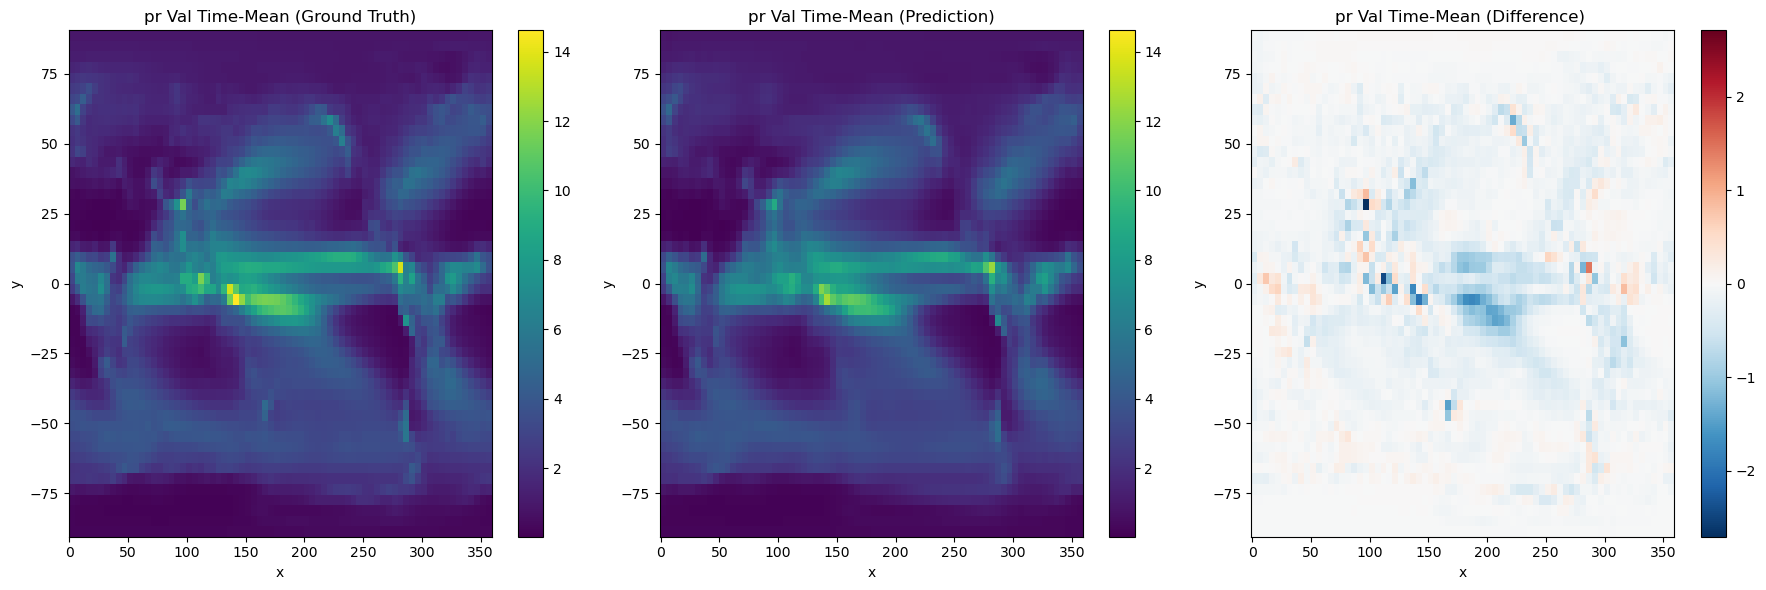

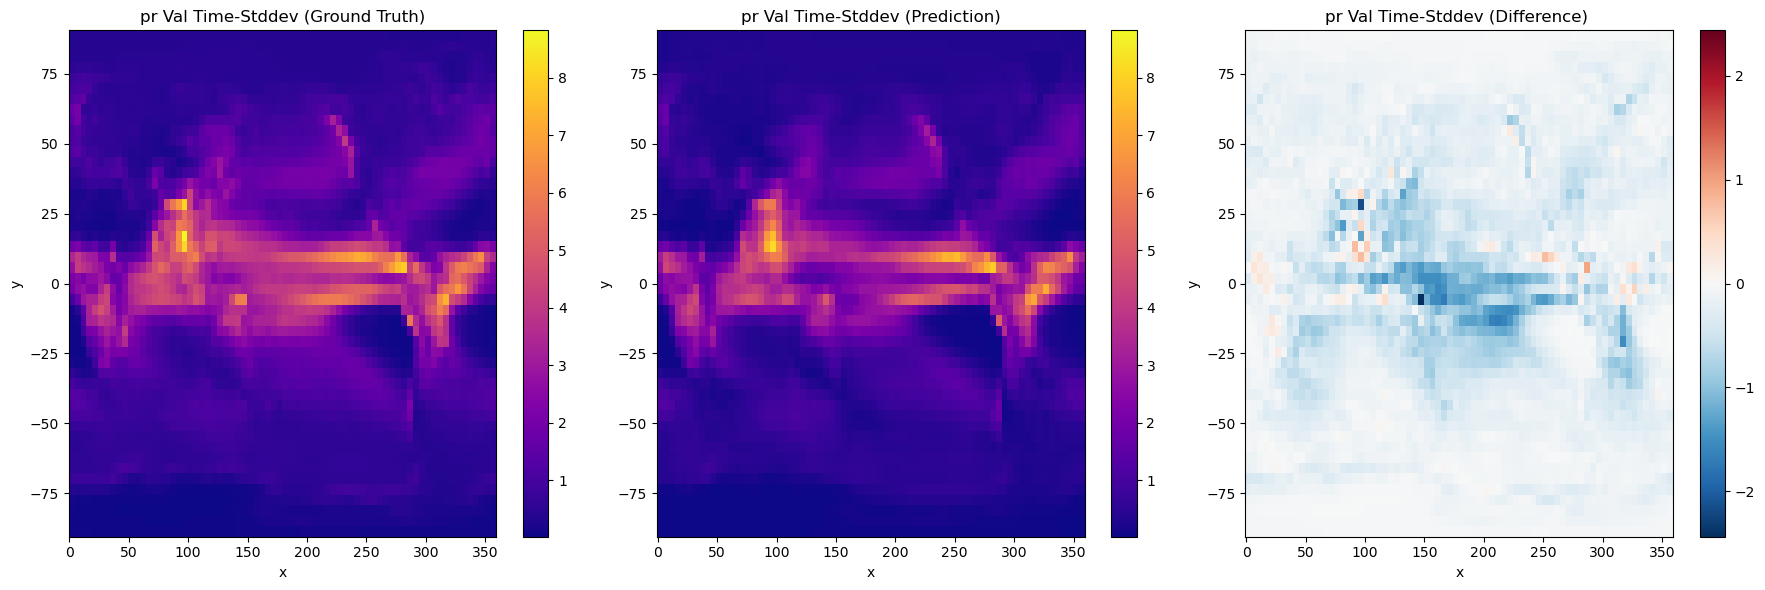

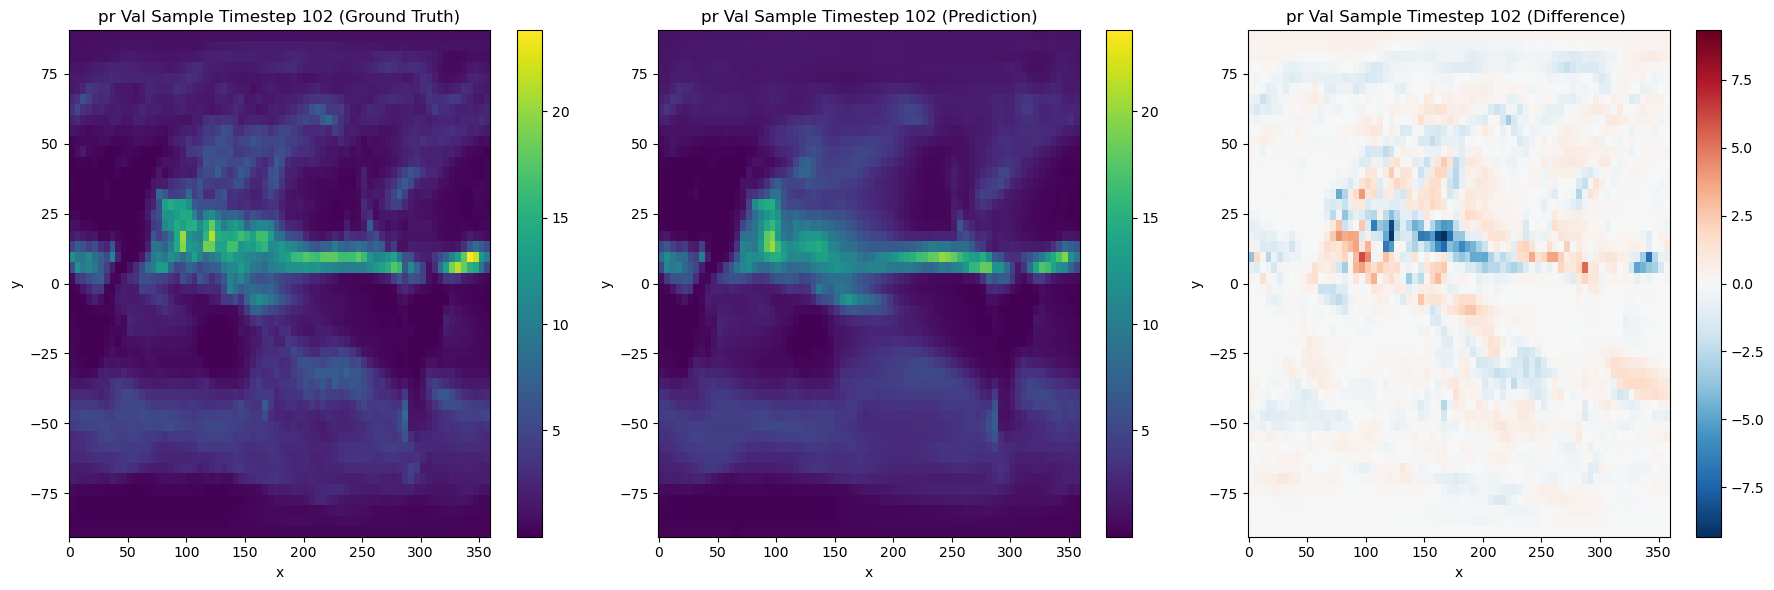

In [63]:
# Load validation predictions
# make sure to have run the validation loop at least once
val_preds = np.load("val_preds.npy")
val_trues = np.load("val_trues.npy")

lat, lon = cdm.get_coords()
output_vars = cdm.output_vars
time = np.arange(val_preds.shape[0])

for i, var in enumerate(output_vars):
    pred_xr = xr.DataArray(val_preds[:, i], dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})
    true_xr = xr.DataArray(val_trues[:, i], dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})

    # --- Time Mean ---
    plot_comparison(true_xr.mean("time"), pred_xr.mean("time"), f"{var} Val Time-Mean")

    # --- Time Stddev ---
    plot_comparison(true_xr.std("time"), pred_xr.std("time"), f"{var} Val Time-Stddev", cmap="plasma")

    # --- Random timestep ---
    t_idx = np.random.randint(0, len(time))
    plot_comparison(true_xr.isel(time=t_idx), pred_xr.isel(time=t_idx), f"{var} Val Sample Timestep {t_idx}")


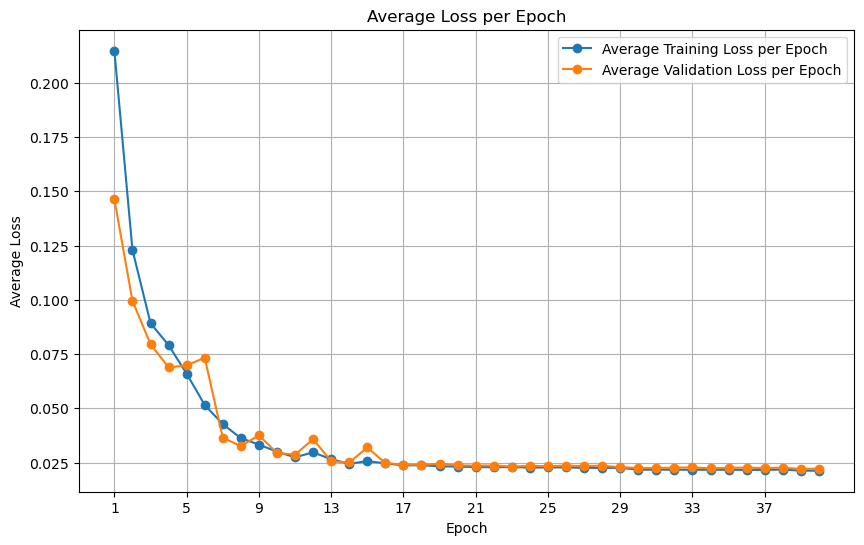

Number of epochs for average training loss: 40
Number of epochs for average validation loss: 40
Total training batches recorded: 3400
Total validation batches recorded: 480
Trainer current epoch (0-indexed for last completed, so +1 for count): 41


In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'climate_model' is your trained ClimateEmulationModule instance
# and 'cdm' is your ClimateDataModule instance.

# These lists contain per-batch losses accumulated during training
training_batch_losses = climate_model.train_losses
validation_batch_losses = climate_model.val_losses

# Get the number of batches per epoch from your dataloaders
# This is important for correctly averaging per epoch
num_train_batches_per_epoch = len(cdm.train_dataloader())
num_val_batches_per_epoch = len(cdm.val_dataloader())

# Calculate average training loss per epoch
avg_train_loss_per_epoch = []
if num_train_batches_per_epoch > 0:
    num_train_epochs_completed = len(training_batch_losses) // num_train_batches_per_epoch
    for i in range(num_train_epochs_completed):
        start_idx = i * num_train_batches_per_epoch
        end_idx = start_idx + num_train_batches_per_epoch
        epoch_train_losses = training_batch_losses[start_idx:end_idx]
        if epoch_train_losses: # Make sure there are losses to average
            avg_train_loss_per_epoch.append(np.mean(epoch_train_losses))

# Calculate average validation loss per epoch
avg_val_loss_per_epoch = []
if num_val_batches_per_epoch > 0:
    num_val_epochs_completed = len(validation_batch_losses) // num_val_batches_per_epoch
    for i in range(num_val_epochs_completed):
        start_idx = i * num_val_batches_per_epoch
        end_idx = start_idx + num_val_batches_per_epoch
        epoch_val_losses = validation_batch_losses[start_idx:end_idx]
        if epoch_val_losses: # Make sure there are losses to average
            avg_val_loss_per_epoch.append(np.mean(epoch_val_losses))

# Create epoch arrays for plotting
epochs_train = np.arange(1, len(avg_train_loss_per_epoch) + 1)
epochs_val = np.arange(1, len(avg_val_loss_per_epoch) + 1)

# Plotting
plt.figure(figsize=(10, 6))
if avg_train_loss_per_epoch:
    plt.plot(epochs_train, avg_train_loss_per_epoch, 'o-', label='Average Training Loss per Epoch')
else:
    print("No average training loss data to plot.")

if avg_val_loss_per_epoch:
    plt.plot(epochs_val, avg_val_loss_per_epoch, 'o-', label='Average Validation Loss per Epoch')
else:
    print("No average validation loss data to plot. This might happen if validation_batch_losses was empty or num_val_batches_per_epoch was zero.")


plt.title('Average Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.grid(True)
# Ensure integer ticks for epochs if data is available
if len(epochs_train) > 0 or len(epochs_val) > 0:
    max_epoch = max(len(epochs_train), len(epochs_val))
    if max_epoch > 0 :
        plt.xticks(np.arange(1, max_epoch + 1, step=max(1, max_epoch // 10))) # Adjust step for readability

plt.show()

# As a sanity check, print the number of epochs for which data was found
print(f"Number of epochs for average training loss: {len(avg_train_loss_per_epoch)}")
print(f"Number of epochs for average validation loss: {len(avg_val_loss_per_epoch)}")
print(f"Total training batches recorded: {len(training_batch_losses)}")
print(f"Total validation batches recorded: {len(validation_batch_losses)}")
if hasattr(trainer, 'current_epoch'):
    print(f"Trainer current epoch (0-indexed for last completed, so +1 for count): {trainer.current_epoch +1 }")